In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

###  <font color='navy'>Data Exploration </font>

In [2]:
#read data into pandas dataframe
diamonds = pd.read_csv('bluenile_xl.csv')

In [3]:
#examine the first few results
diamonds.head()

,id,carat,shapeName,clarity,color,culet,cut,depth,fluorescence,lxwRatio,polish,symmetry,table,price
0,LD13939631,0.23,Round,SI1,D,None,Ideal,59.4,Faint,1.00,Very Good,Very Good,60.0,$280
1,LD12101461,0.23,Round,SI1,D,None,Good,65.3,Very Strong,1.01,Very Good,Very Good,55.0,$288
2,LD13420093,0.24,Round,SI1,D,None,Ideal,59.8,None,1.00,Very Good,Excellent,59.0,$289
3,LD13855335,0.25,Round,SI2,D,None,Very Good,60.0,None,1.00,Good,Very Good,59.0,$290
4,LD11975555,0.23,Round,SI2,D,None,Good,64.1,None,1.00,Very Good,Good,59.0,$291


In [4]:
#dimensions of the dataset
diamonds.shape

(21245, 14)

In [5]:
#print a concise summary of the dataset
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21245 entries, 0 to 21244
Data columns (total 14 columns):
id              21245 non-null object
carat           21245 non-null float64
shapeName       21245 non-null object
clarity         21245 non-null object
color           21245 non-null object
culet           21245 non-null object
cut             21245 non-null object
depth           21245 non-null float64
fluorescence    21245 non-null object
lxwRatio        21245 non-null float64
polish          21245 non-null object
symmetry        21245 non-null object
table           21245 non-null float64
price           21245 non-null object
dtypes: float64(4), object(10)
memory usage: 2.3+ MB


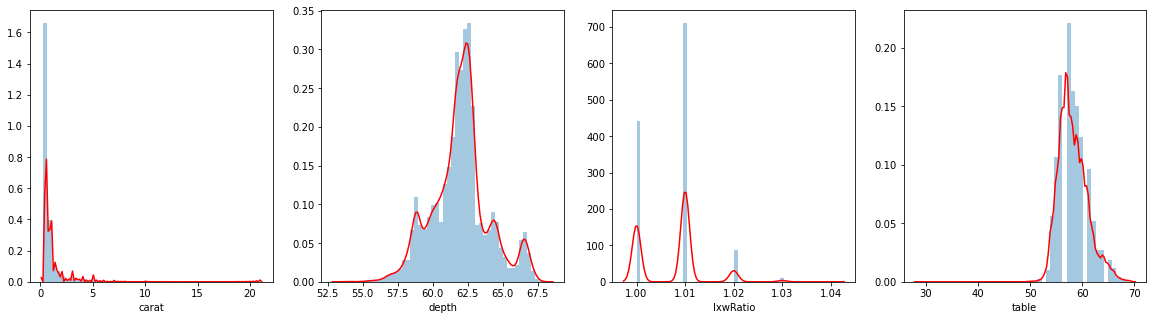

In [6]:
# the numerical variables are carat, depth, lxwRatio and table
f, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(diamonds['carat'], kde_kws={"color":"red"},ax=ax[0])
sns.distplot(diamonds['depth'], kde_kws={"color":"red"},ax=ax[1])
sns.distplot(diamonds['lxwRatio'] , kde_kws={"color":"red"},ax=ax[2])
sns.distplot(diamonds['table'].fillna(0) , kde_kws={"color":"red"},ax=ax[3])
plt.show()

In [7]:
# lxwRatio is a discreate variable
diamonds['lxwRatio'].value_counts()

1.01    12077
1.00     7518
1.02     1480
1.03      169
1.04        1
Name: lxwRatio, dtype: int64

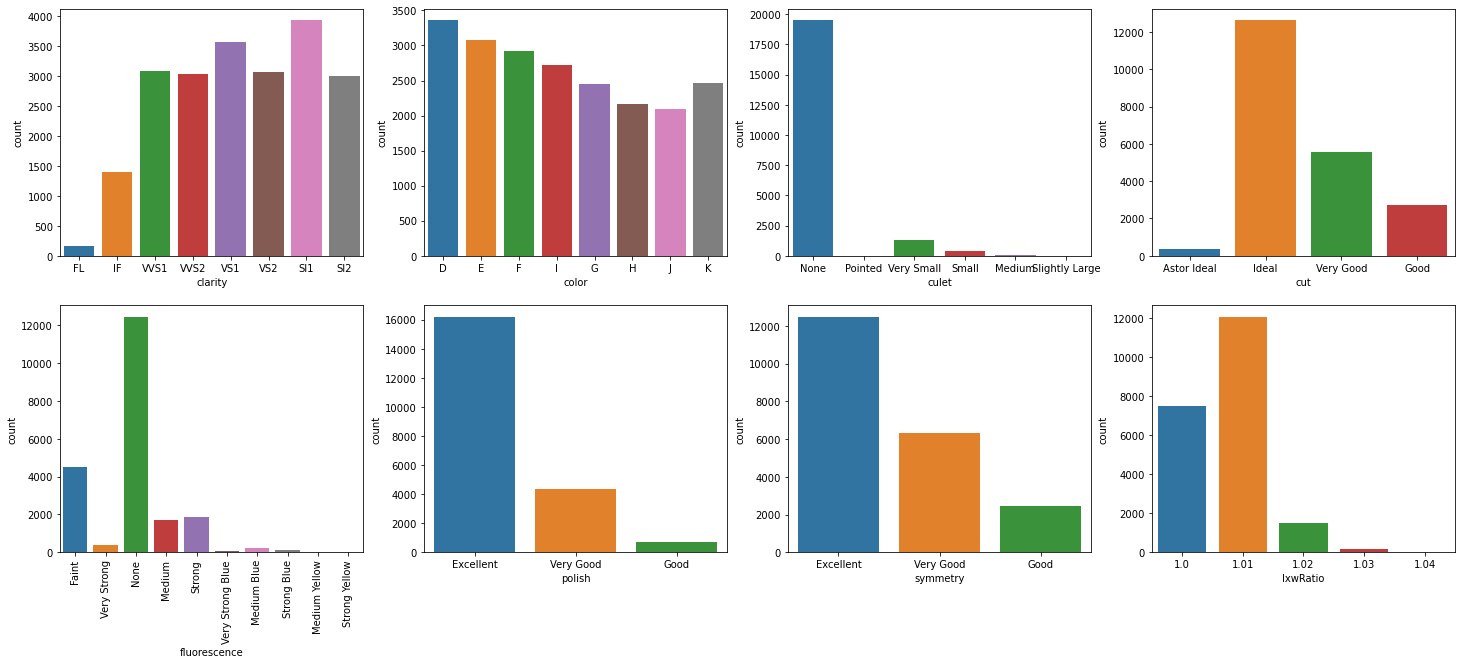

In [8]:
# plottig categorical variables
f, ax = plt.subplots(2, 4, figsize=(25, 10))
sns.countplot(x='clarity', data=diamonds, order=['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2'] ,ax=ax[0,0])
sns.countplot(x='color', data=diamonds, ax=ax[0,1])
sns.countplot(x='culet', data=diamonds, ax=ax[0,2], order=['None', 'Pointed', 'Very Small', 'Small', 'Medium', 'Slightly Large'])
sns.countplot(x='cut', data=diamonds, ax=ax[0,3], order=['Astor Ideal', 'Ideal', 'Very Good', 'Good'])
sns.countplot(x='fluorescence', data=diamonds, ax=ax[1,0])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation=90)
sns.countplot(x='polish', data=diamonds, ax=ax[1,1], order =['Excellent', 'Very Good', 'Good'])
sns.countplot(x='symmetry', data=diamonds, ax=ax[1,2], order=['Excellent', 'Very Good', 'Good'])
sns.countplot(x='lxwRatio', data=diamonds, ax=ax[1,3])
plt.show()

###  <font color='navy'>Data Preprocessing </font>

In [9]:
#remove $ from price
diamonds['price'] = diamonds['price'].str.replace('$', '')

# remove comma from price
diamonds['price'] = diamonds['price'].str.replace(',', '')

In [10]:
# covert price to number
diamonds['price'] = diamonds['price'].astype('float')

In [11]:
#descriptive statistics of target variable diamond price
diamonds['price'].describe()

count    2.124500e+04
mean     8.445621e+03
std      4.014354e+04
min      2.500000e+02
25%      4.920000e+02
50%      8.050000e+02
75%      2.899000e+03
max      2.561004e+06
Name: price, dtype: float64

In [12]:
# price quantitles 
diamonds['price'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95,0.99,1])

0.00        250.0
0.05        342.0
0.25        492.0
0.50        805.0
0.75       2899.0
0.95      43795.0
0.99     131575.2
1.00    2561004.0
Name: price, dtype: float64

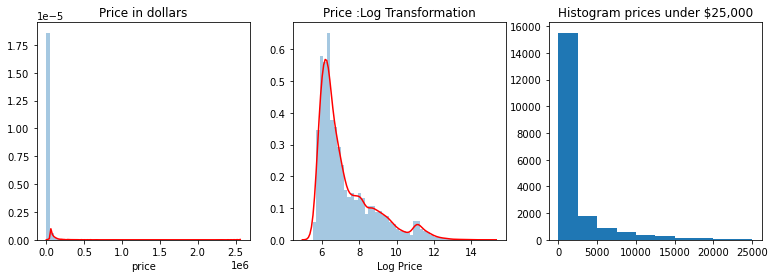

In [13]:
#plot prce histogram alongside with the KDE plot
fig , ax = plt.subplots(1,3, figsize=(13, 4))
sns.distplot(diamonds['price'],kde_kws={"color":"red"}, ax=ax[0])
ax[0].set_title('Price in dollars')
sns.distplot(np.log(diamonds['price']), kde_kws={"color":"red"}, ax=ax[1])
ax[1].set_title('Price :Log Transformation')
ax[1].set_xlabel('Log Price')
ax[2].hist(diamonds['price'], range=[0,25000])
ax[2].set_title('Histogram prices under $25,000')
plt.show()

Range of the diamond prices are very wide , as cheap as 250 dollars to little over 2.5million dollars. In fact, 99% of the diamond prices are less than $128,500. Because the of the high postive skew, we will apply a log transformation (and attempt to predict the log prices than price)

In [14]:
# add a new column log_price
diamonds['log_price'] = np.log(diamonds['price'])

In [15]:
# Clarity of a diamond has ordering , we will convert the cateogrical variable into ordinal representation
#['FL' > 'IF' > 'VVS1'> 'VVS2'> 'VS1'> 'VS2'> 'SI1' >'SI2']
mapping = {'FL':7, 'IF':6, 'VVS1':5, 'VVS2':4, 'VS1':3, 'VS2':2, 'SI1':1, 'SI2':0}
diamonds['clarity_ord'] = diamonds['clarity'].map(mapping)

In [16]:
# similarly color also has an order 
mapping = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1, 'K':0}
diamonds['color_ord'] = diamonds['color'].map(mapping) 

In [17]:
# cut is ordinal too
mapping = {'Astor Ideal':3, 'Ideal':2, 'Very Good':1, 'Good':0}
diamonds['cut_ord'] = diamonds['cut'].map(mapping)

In [18]:
# polish and symmetry 
mapping = {'Excellent':2, 'Very Good':1, 'Good':0}
diamonds['polish_ord'] = diamonds['polish'].map(mapping)
diamonds['symmetry_ord'] = diamonds['symmetry'].map(mapping)

In [19]:
diamonds['culet'].value_counts()

None              19483
Very Small         1289
Small               371
Medium               92
Pointed               7
Slightly Large        3
Name: culet, dtype: int64

In [20]:
# culet is ordinal 
mapping ={'None':5, 'Pointed':4, 'Very Small':3, 'Small':2, 'Medium':1, 'Slightly Large':0}
diamonds['culet_ord'] = diamonds['culet'].map(mapping)

In [21]:
#frequency of fluorescence
diamonds['fluorescence'].value_counts()

None                12450
Faint                4517
Strong               1844
Medium               1695
Very Strong           371
Medium Blue           203
Strong Blue           109
Very Strong Blue       53
Medium Yellow           2
Strong Yellow           1
Name: fluorescence, dtype: int64

In [22]:
mapping = {'Medium Blue': 'Medium', 'Strong Blue':'Strong', 'Very Strong Blue':'Very Strong', 
           'Medium Yellow':'Medium', 'Strong Yellow':'Strong'}
diamonds['fluorescence'] = diamonds['fluorescence'].replace(mapping)

In [23]:
#verify this is done correctly
diamonds['fluorescence'].value_counts()

None           12450
Faint           4517
Strong          1954
Medium          1900
Very Strong      424
Name: fluorescence, dtype: int64

In [24]:
# fluorescence has a natural ordering
mapping = {'None':4, 'Faint':3, 'Medium':2, 'Strong':1, 'Very Strong':0}
diamonds['fluorescence_ord'] = diamonds['fluorescence'].map(mapping)

In [25]:
#inspect the dataframe
diamonds.head()

,id,carat,shapeName,clarity,color,culet,cut,depth,fluorescence,lxwRatio,...,table,price,log_price,clarity_ord,color_ord,cut_ord,polish_ord,symmetry_ord,culet_ord,fluorescence_ord
0,LD13939631,0.23,Round,SI1,D,None,Ideal,59.4,Faint,1.00,...,60.0,280.0,5.634790,1,7,2,1,1,5,3
1,LD12101461,0.23,Round,SI1,D,None,Good,65.3,Very Strong,1.01,...,55.0,288.0,5.662960,1,7,0,1,1,5,0
2,LD13420093,0.24,Round,SI1,D,None,Ideal,59.8,None,1.00,...,59.0,289.0,5.666427,1,7,2,1,2,5,4
3,LD13855335,0.25,Round,SI2,D,None,Very Good,60.0,None,1.00,...,59.0,290.0,5.669881,0,7,1,0,1,5,4
4,LD11975555,0.23,Round,SI2,D,None,Good,64.1,None,1.00,...,59.0,291.0,5.673323,0,7,0,1,0,5,4


In [26]:
# names of the columns in the dataframe
diamonds.columns

Index(['id', 'carat', 'shapeName', 'clarity', 'color', 'culet', 'cut', 'depth',
       'fluorescence', 'lxwRatio', 'polish', 'symmetry', 'table', 'price',
       'log_price', 'clarity_ord', 'color_ord', 'cut_ord', 'polish_ord',
       'symmetry_ord', 'culet_ord', 'fluorescence_ord'],
      dtype='object')

In [27]:
# columns to drop, id is unique to each diamond so not very useful. There is only one shape (round)
cols_to_drop = ['id', 'shapeName','clarity', 'color', 'culet', 'cut', 'fluorescence','polish', 'symmetry', 'price', 'log_price']
X = diamonds.drop(cols_to_drop, axis=1)
y = diamonds.log_price.values

###  <font color='navy'>Train and Compare Regressors</font>

In [28]:
#set seed for reprodusibility
SEED = 1411

# split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=SEED)

In [29]:
#instantiate the regressors
rfr = RandomForestRegressor(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)
abr = AdaBoostRegressor(random_state=SEED)

In [30]:
#list of regressors
regr_list = [rfr, gbr, abr]

#list of regressor names 
regr_names = ['Random Forest', 'Gradient Boost', 'Ada Boost']

In [31]:
#Metrics of interest
cv_list=[]
r2_list =[]
mse_list =[]
rmse_list=[]
mae_list =[]

In [32]:
#for each regressor in the list do the following : 
for regr in regr_list:
    # calculate 5-fold cross validation R-square
    cv_scores = cross_val_score(regr,X_train, y_train, scoring='r2', cv=5)
    cv_list.append(cv_scores.mean())
    
    #fit the training set
    regr.fit(X_train, y_train)
    
    #make prediction
    y_pred = regr.predict(X_test)
    
    #calcuate test set R-square
    r2_list.append(r2_score(y_test, y_pred))
    
    #calculate MSE and RMSE
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    rmse_list.append(np.sqrt(mse))

    # calculate mean absolute error
    mae_list.append(mean_absolute_error(y_test, y_pred))

In [33]:
regr_summary = pd.DataFrame(list(zip(regr_names, cv_list, r2_list, mse_list,rmse_list,mae_list)),
                          columns=[ 'Regressor','Crossval R-sq','R-square', 'MSE', 'RMSE', 'MAE']
                         )
regr_summary.round(3)

,Regressor,Crossval R-sq,R-square,MSE,RMSE,MAE
0,Random Forest,0.992,0.993,0.017,0.130,0.095
1,Gradient Boost,0.991,0.991,0.020,0.142,0.110
2,Ada Boost,0.959,0.961,0.089,0.298,0.248


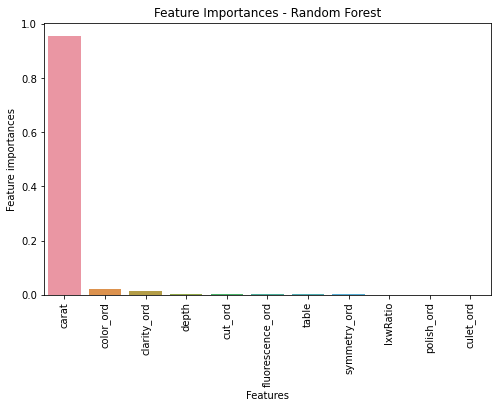

In [76]:
#plot Feature Importance
df_coef_rf = pd.DataFrame({'Features': X.columns, 'Feature importances': rfr.feature_importances_})
df_coef_rf = df_coef_rf.sort_values(by='Feature importances',ascending=False)
plt.figure(figsize = (8,5))
plt.title('Feature Importances - Random Forest')
s=sns.barplot(x='Features',y='Feature importances',data=df_coef_rf)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

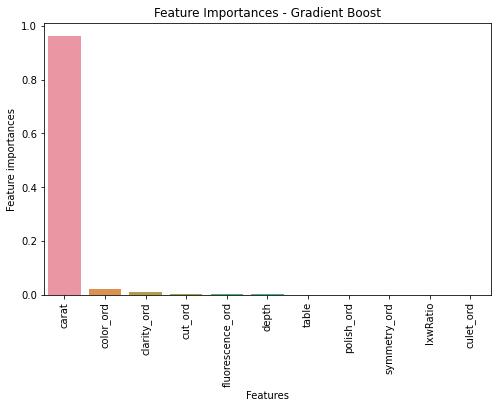

In [77]:
#plot Feature Importance GB
df_coef_gb = pd.DataFrame({'Features': X.columns, 'Feature importances': gbr.feature_importances_})
df_coef_gb = df_coef_gb.sort_values(by='Feature importances',ascending=False)
plt.figure(figsize = (8,5))
plt.title('Feature Importances - Gradient Boost')
s=sns.barplot(x='Features',y='Feature importances',data=df_coef_gb)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

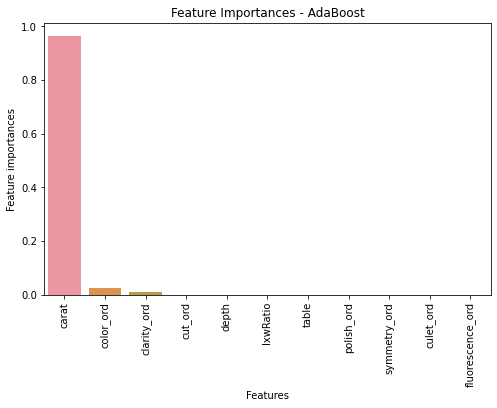

In [78]:
#plot Feature Importance AdaBoost
df_coef_ab = pd.DataFrame({'Features': X.columns, 'Feature importances': abr.feature_importances_})
df_coef_ab = df_coef_ab.sort_values(by='Feature importances',ascending=False)
plt.figure(figsize = (8,5))
plt.title('Feature Importances - AdaBoost')
s=sns.barplot(x='Features',y='Feature importances',data=df_coef_ab)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

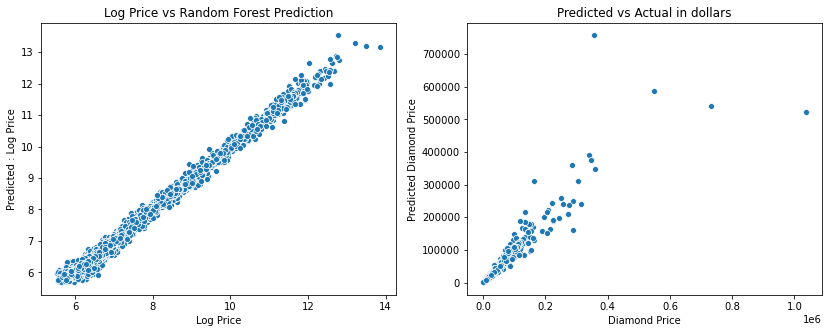

In [72]:
#make prediction using the best model
y_pred_rf = rfr.predict(X_test)

# plot predicted vs actual price for test set
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(y_test, y_pred_rf, ax=ax[0])
ax[0].set_title('Log Price vs Random Forest Prediction')
ax[0].set_xlabel('Log Price')
ax[0].set_ylabel('Predicted : Log Price')
sns.scatterplot(np.exp(y_test), np.exp(y_pred_rf), ax=ax[1])
ax[1].set_title('Predicted vs Actual in dollars')
ax[1].set_xlabel('Diamond Price')
ax[1].set_ylabel('Predicted Diamond Price')
plt.show()

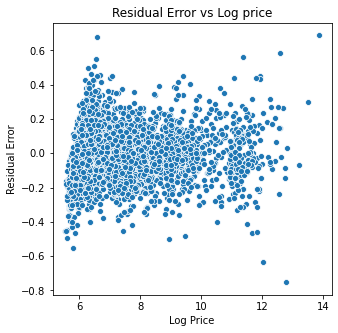

In [36]:
# residual error => Log price - predicted log price
residual =  y_test - y_pred_rf
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(y_test, residual, ax=ax)
ax.set_title('Residual Error vs Log price')
ax.set_xlabel('Log Price')
ax.set_ylabel('Residual Error')
plt.show()

In [37]:
# predict prices for both train and test set
predicted_prices = rfr.predict(X)
diamonds['Predicted'] = np.exp(predicted_prices)
diamonds['Error'] = diamonds['price'] - diamonds['Predicted'] # actual minus prediction

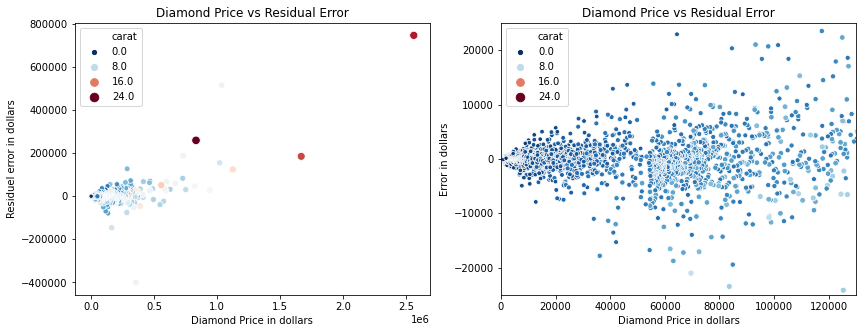

In [38]:
#Plot Price vs Residual Error, see if the size of the carat is the reason for larger errors 
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot('price', 'Error', hue='carat',size='carat',palette="RdBu_r",data=diamonds, ax=ax[0])
ax[0].set_title('Diamond Price vs Residual Error')
ax[0].set_xlabel('Diamond Price in dollars')
ax[0].set_ylabel('Residuel error in dollars')

#Recall 99% of the diamond samples are priced less than 128K. The reason for larger errors could simply be not enough data
sns.scatterplot('price', 'Error', hue='carat',size='carat',palette="RdBu_r",data=diamonds, ax=ax[1])
ax[1].set_title('Diamond Price vs Residual Error')
ax[1].set_xlabel('Diamond Price in dollars')
ax[1].set_ylabel('Error in dollars')
ax[1].set_ylim(-25000, 25000)
ax[1].set_xlim(0, 130000)
plt.show()

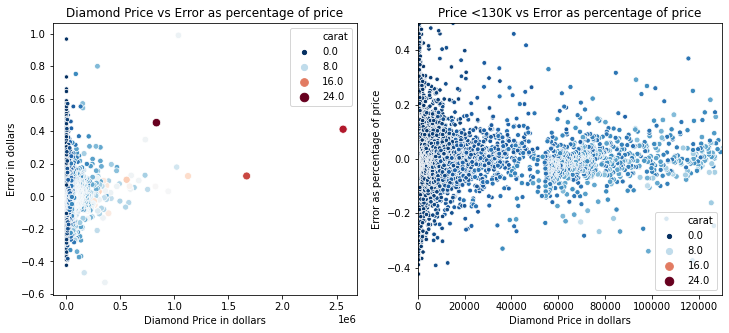

In [39]:
diamonds['Error_pct'] = (diamonds['price']/diamonds['Predicted'])-1
#Plot Price vs Error, see if the size of the carat is the reason for larger errors 
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot('price', 'Error_pct', hue='carat',size='carat',palette="RdBu_r",data=diamonds, ax=ax[0])
ax[0].set_title('Diamond Price vs Error as percentage of price')
ax[0].set_xlabel('Diamond Price in dollars')
ax[0].set_ylabel('Error in dollars')

#Note 99% of the diamond samples are priced less than 128K values. The reason for larger errors could simply be not enough data
sns.scatterplot('price', 'Error_pct', hue='carat',size='carat',palette="RdBu_r",data=diamonds, ax=ax[1])
ax[1].set_title('Price <130K vs Error as percentage of price')
ax[1].set_xlabel('Diamond Price in dollars')
ax[1].set_ylabel('Error as percentage of price')
ax[1].set_xlim(0, 130000)
ax[1].set_ylim(-0.5, 0.5)
plt.show()

### Dimensionality Reduction with Automatic Recursive Feature Elimination (RFE)

*From the feature importance chart it looks like only a handful of features are contributing most to the prediction. However dropping one weak feature may make other features relatively more or less important.Scikit learn's automatic recursive feature elimination functionality offers a way to minimise the risk of dropping the wrong features by dropping weak features one by one. In this section we will use RFE build a model with only a handful of features and evaluate the model performance*

In [59]:
from sklearn.feature_selection import RFE

The features importance chart above showed carat as the most important feature followed by color and clarity. We will model diamond prices using 4 features with the fourth feature to capture information in the other variables

In [60]:
# Create the RFE with a GB estimator and 4 features 
rfe = RFE(estimator=gbr, n_features_to_select=4, verbose=1)

In [61]:
# Fits the eliminator to the data
rfe.fit(X_train, y_train)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.


RFE(estimator=GradientBoostingRegressor(random_state=1411),
    n_features_to_select=4, verbose=1)

In [63]:
# Print the features and their ranking (high = dropped early on), 1 =Features Kept
import pprint
pp = pprint.PrettyPrinter()
ranking_dict = dict(zip(X.columns, rfe.ranking_))
ranking_dict = sorted(ranking_dict.items(), key=lambda item: item[1], reverse=True)
pp.pprint(ranking_dict)

[('culet_ord', 8),
 ('lxwRatio', 7),
 ('symmetry_ord', 6),
 ('polish_ord', 5),
 ('table', 4),
 ('depth', 3),
 ('fluorescence_ord', 2),
 ('carat', 1),
 ('clarity_ord', 1),
 ('color_ord', 1),
 ('cut_ord', 1)]


In [64]:
# Print the features that are not eliminated
print(X.columns[rfe.support_])

Index(['carat', 'clarity_ord', 'color_ord', 'cut_ord'], dtype='object')


RFE has selected the carat, clarity , color and cut . This is interesting since the [domain knowledge](https://www.bluenile.com/education/diamonds) suggests the 4Cs that determine the diamond prices are carat, colour, clarity and cut too.

In [65]:
#make prediction
y_pred_rfe = rfe.predict(X_test)

In [66]:
# calc test set r-sq
rfe_rsq = r2_score(y_test, y_pred_rfe)

# mse
rfe_mse = mean_squared_error(y_test, y_pred_rfe)

# rmse 
rfe_rmse = np.sqrt(rfe_mse)

# mae
rfe_mae = mean_absolute_error(y_test, y_pred_rfe)

In [67]:
print("RFE R-sq={}, MSE={}, RMSE={}, MAE={}".format(rfe_rsq,rfe_mse,rfe_rmse,rfe_mae))

RFE R-sq=0.9897653229896789, MSE=0.023049740239580976, RMSE=0.15182140902909896, MAE=0.11688786135148574


#### Appendix : Finding cheap diamonds

In [68]:
# rounding to make it more reabable
diamonds['Predicted'] = diamonds['Predicted'].round(0)
diamonds['Error'] = diamonds['Error'].round(0)
diamonds['Error_pct'] = diamonds['Error_pct'].round(2)

In [49]:
#top cheap diamonds (dollars)
diamonds.sort_values(by='Error')[['id', 'carat','price', 'Predicted', 'Error']].head(10)

,id,carat,price,Predicted,Error
1033,LD13151377,10.03,356542.0,757202.0,-400660.0
1139,LD11860282,8.43,164992.0,311070.0,-146078.0
1199,LD12468309,5.02,135673.0,214705.0,-79032.0
1055,LD13941280,8.01,284880.0,360491.0,-75611.0
1277,LD13702073,5.00,117285.0,187116.0,-69831.0
1037,LD13126106,10.08,338916.0,390762.0,-51846.0
1369,LD13130587,5.35,98477.0,149124.0,-50647.0
1202,LD10702992,5.01,134584.0,184430.0,-49846.0
1028,LD13705309,11.56,389526.0,434819.0,-45293.0
1229,LD13697954,5.01,126463.0,167731.0,-41268.0


In [50]:
#top cheap diamonds (% discount)
diamonds.sort_values(by='Error_pct')[['id', 'carat','price', 'Predicted', 'Error_pct']].head(10)

,id,carat,price,Predicted,Error_pct
1033,LD13151377,10.03,356542.0,757202.0,-0.53
1139,LD11860282,8.43,164992.0,311070.0,-0.47
6865,LD13884849,0.35,323.0,560.0,-0.42
6541,LD13885379,0.31,264.0,432.0,-0.39
5437,LD13870396,1.50,7654.0,12586.0,-0.39
13391,LD12463682,1.51,12754.0,20666.0,-0.38
5131,LD13585693,0.71,1697.0,2678.0,-0.37
7260,LD09851468,0.32,350.0,557.0,-0.37
1277,LD13702073,5.00,117285.0,187116.0,-0.37
1199,LD12468309,5.02,135673.0,214705.0,-0.37


In [51]:
#findnig a diamond within a budget
diamonds[(diamonds.price > 5000)& (diamonds.price <6000)].sort_values(by='Error')[['id', 'carat','price', 'Predicted', 'Error']].head(10)
# diamonds[(diamonds.price < 10000)].sort_values(by='Error')[['id', 'carat','price', 'Predicted', 'Error']].head(10)

,id,carat,price,Predicted,Error
2421,LD13974854,1.00,5414.0,7140.0,-1726.0
21090,LD13343734,1.29,5607.0,6656.0,-1049.0
13709,LD12734797,1.32,5651.0,6577.0,-926.0
21086,LD10063099,1.00,5452.0,6376.0,-924.0
18247,LD13962247,1.13,5213.0,6087.0,-874.0
5875,LD13798829,1.00,5387.0,6238.0,-851.0
2691,LD13974282,1.11,5446.0,6291.0,-845.0
15272,LD13515590,0.90,5246.0,6082.0,-836.0
5177,LD13803916,1.00,5713.0,6539.0,-826.0
2004,LD13976248,1.00,5217.0,6011.0,-794.0
